In [1]:
import cv2 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow import keras
import seaborn as sns
from keras.models import Sequential,load_model
from keras.layers import LeakyReLU,Conv2D,Activation, MaxPooling2D,Dense,Flatten,ReLU
import matplotlib.pyplot as plt_False_Positive_vs_True_Positive
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


In [2]:

BASE_DIR = Path().resolve().parent
waste = BASE_DIR / "/content/drive/MyDrive/Colab Notebooks/detection _waste"
waste.mkdir(exist_ok= True,parents=True)
train_data = waste / "/content/drive/MyDrive/Colab Notebooks/detection _waste/train"
train_data.mkdir(exist_ok= True,parents=True)
test_data = train_data / "/content/drive/MyDrive/Colab Notebooks/detection _waste/test"
test_data.mkdir(exist_ok= True,parents=True)
train_data



PosixPath('/content/drive/MyDrive/Colab Notebooks/detection _waste/train')

# -------------------------------------------------------------------------
#                        **Build CNN Model** 
# -------------------------------------------------------------------------

In [3]:
model = keras.Sequential()
model.add(keras.Input(shape=(250, 250, 3)))  # 250x250x3 RGB images
model.add(keras.layers.Conv2D(32, 5, strides=2, use_bias=False))  # output: 123x123x32
model.add(keras.layers.BatchNormalization(axis=3))  # Axis=3 "channels" is the 3rd axis of default data_format(batch_size, height, width, channels)
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(64, 3, use_bias=False))  # output: 121x121x64
model.add(keras.layers.BatchNormalization(axis=3))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.MaxPooling2D(3))  # output: 40x40x64

model.add(keras.layers.Conv2D(128, 3, use_bias=False))  # output: 38x38x128
model.add(keras.layers.BatchNormalization(axis=3))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.MaxPooling2D(3))  # output: 12x12x128

# Classification layer.
model.add(keras.layers.Flatten())  # 1x1x18432
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))  # 1x1x128
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 1x1x1

opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)  # w = w + momentum * velocity - lr * grad
# compile model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

#  Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      2400      
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 123, 123, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 121, 64)      18432     
                                                                 
 batch_normalization_1 (Batc  (None, 121, 121, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 121, 121, 64)      0

# -------------------------------------------------------------------------
#                        **Train CNN Model** 
# -------------------------------------------------------------------------

In [4]:

# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterators
train_it = datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/detection _waste/train', class_mode='binary', batch_size=64, target_size=(250, 250))
test_it = datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/detection _waste/test', class_mode='binary', batch_size=64, target_size=(250, 250))
# fit model
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20)
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it,
                     validation_steps=len(test_it), epochs=20, verbose=1, callbacks=[es], workers=10)


Found 708 images belonging to 2 classes.
Found 173 images belonging to 2 classes.
Epoch 1/20
12/12 [==============================] - 108s 8s/step - loss: 0.7354 - accuracy: 0.6568 - val_loss: 0.7071 - val_accuracy: 0.2775
Epoch 2/20
12/12 [==============================] - 73s 5s/step - loss: 0.7491 - accuracy: 0.7076 - val_loss: 0.7829 - val_accuracy: 0.3121
Epoch 3/20
12/12 [==============================] - 73s 5s/step - loss: 0.6209 - accuracy: 0.7119 - val_loss: 0.6876 - val_accuracy: 0.6647
Epoch 4/20
12/12 [==============================] - 73s 5s/step - loss: 0.4885 - accuracy: 0.7599 - val_loss: 0.6861 - val_accuracy: 0.6647
Epoch 5/20
12/12 [==============================] - 77s 6s/step - loss: 0.4774 - accuracy: 0.7585 - val_loss: 0.7104 - val_accuracy: 0.4104
Epoch 6/20
12/12 [==============================] - 74s 6s/step - loss: 0.4502 - accuracy: 0.7924 - val_loss: 0.7158 - val_accuracy: 0.4855
Epoch 7/20
12/12 [==============================] - 73s 5s/step - loss: 0.425

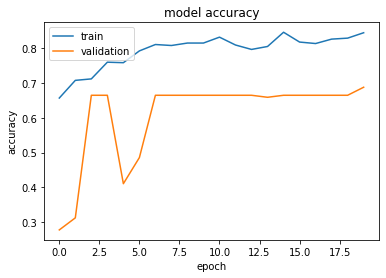

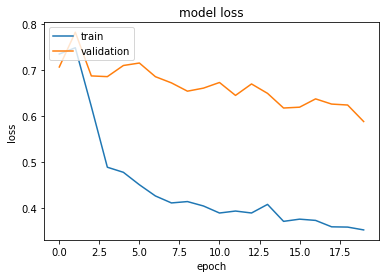

In [5]:

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# save model
model.save('detection_waste_plastic.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)


# -------------------------------------------------------------------------
#                        **Evaluate CNN Model** 
# -------------------------------------------------------------------------

3/3 [==============================] - 5s 1s/step

Confusion Matrix
 -------------------------
[[  0  58]
 [  2 113]]
Accuracy: 0.653179
Precision: 0.660819
Recall: 0.982609
F1 score: 0.790210
ROC AUC: 0.439730


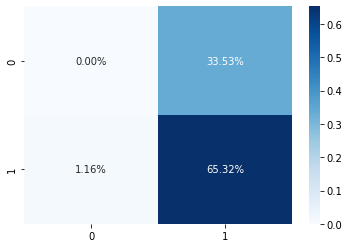

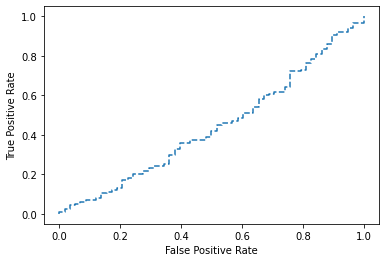

In [6]:

# load model
model = load_model('detection_waste_plastic.h5')
 
# load test data
y_true = test_it.classes
y_pred = model.predict(test_it, steps=len(test_it), verbose=1)


y_pred_prob = y_pred[:]
y_pred_binary =  y_pred_prob > 0.5

#Confution Matrix    
print('\nConfusion Matrix\n -------------------------')    
print(confusion_matrix(y_true,y_pred_binary))

sns.heatmap(confusion_matrix(y_true,y_pred_binary)/np.sum(confusion_matrix(y_true,y_pred_binary)), annot=True, 
        fmt='.2%', cmap='Blues')

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred_binary)
print('Accuracy: %f' % accuracy)


# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_binary)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_binary)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_binary)
print('F1 score: %f' % f1)    
    
# ROC AUC
auc = roc_auc_score(y_true, y_pred_prob)
print('ROC AUC: %f' % auc)


# calculate roc curves
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
# plot the roc curve for the model
plt.figure()
plt_False_Positive_vs_True_Positive.plot(fpr, tpr, linestyle='--', label='')

# axis labels
plt_False_Positive_vs_True_Positive.xlabel('False Positive Rate')
plt_False_Positive_vs_True_Positive.ylabel('True Positive Rate')

        
# show the plot
plt_False_Positive_vs_True_Positive.show()


# -------------------------------------------------------------------------
#                        **TEST CNN Model** 
# -------------------------------------------------------------------------

In [7]:


model = load_model('detection_waste_plastic.h5')

probabilities = model.predict(test_it)
print(probabilities)  

3/3 [==============================] - 7s 2s/step
[[0.7605243 ]
 [0.91418815]
 [0.9195454 ]
 [0.8611119 ]
 [0.7243215 ]
 [0.69219005]
 [0.85186046]
 [0.75432473]
 [0.6845623 ]
 [0.7766146 ]
 [0.845288  ]
 [0.73515666]
 [0.7023032 ]
 [0.519959  ]
 [0.95080715]
 [0.8449499 ]
 [0.8487075 ]
 [0.6602671 ]
 [0.64270216]
 [0.80891526]
 [0.83396775]
 [0.75530374]
 [0.8504691 ]
 [0.76219463]
 [0.6949013 ]
 [0.74014515]
 [0.826974  ]
 [0.8342018 ]
 [0.72789496]
 [0.7416821 ]
 [0.9286959 ]
 [0.727614  ]
 [0.7841906 ]
 [0.58535385]
 [0.6882015 ]
 [0.7766429 ]
 [0.89035845]
 [0.82466584]
 [0.4773211 ]
 [0.6540497 ]
 [0.9373635 ]
 [0.59368294]
 [0.68542904]
 [0.9241882 ]
 [0.8404727 ]
 [0.7902531 ]
 [0.88032985]
 [0.8214775 ]
 [0.6496846 ]
 [0.66958404]
 [0.72453547]
 [0.93454486]
 [0.79335654]
 [0.88386613]
 [0.8632381 ]
 [0.8412505 ]
 [0.6679089 ]
 [0.6969803 ]
 [0.9519979 ]
 [0.79913294]
 [0.84107023]
 [0.90644544]
 [0.88107336]
 [0.8488979 ]
 [0.7361689 ]
 [0.7167749 ]
 [0.51028895]
 [0.70275795

In [8]:
y_pred = probabilities > 0.5 

classit = [['plastic' for x in y_pred  if x[0]== True] ,['others_waste' for x in y_pred if x[0]==False]]
classit 
class_names = ['plastic','others_waste']
print(classit)



[['plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic', 'plastic